# Striplog merge

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

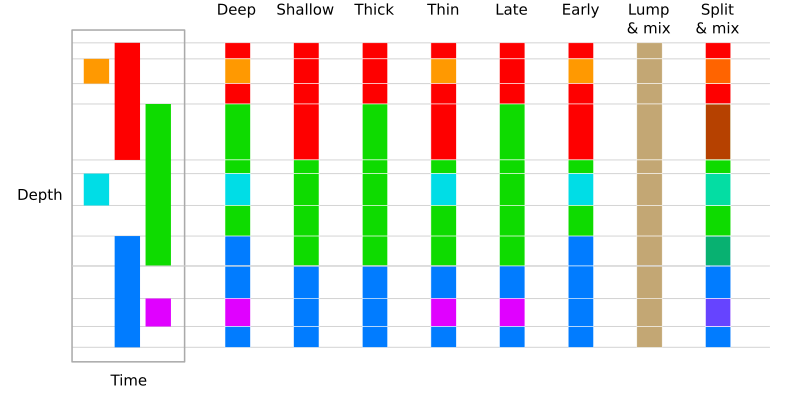

In [49]:
from IPython.display import Image
Image('./merging.png')

Other possibility is using the deepest or shallowest **base** rather than top.

In [50]:
csv = """Top,Base,Comp Time,Comp Depth
100,200,2,a
110,120,1,b
150,325,3,c
210,225,1,d
300,400,2,e
350,375,3,f
"""

leg_csv = """Colour,Comp Depth
red,a
orange,b
limegreen,c
cyan,d
blue,e
magenta,f
"""

In [51]:
from striplog import Striplog, Legend

s = Striplog.from_csv(text=csv)
legend = Legend.from_csv(text=leg_csv)

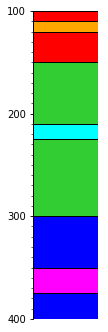

In [52]:
s.plot(legend=legend,lw=1, aspect=3)

In [53]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 200.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'time': 2.0, 'depth': 'a'})]})

## Merge

Strategy:

- **TABLE.** Make a '`table` of the tops and bases we encounter, starting at the top. We will need to know 3 things: whether it's a top or a base, the depth it's at, and which interval in the striplog it corresponds to.
- **APPLY RULE.** Work our way down this table applying a precedence rule (shallowest, thickest, etc). This will let us build a 'stack' which records the units we're currently 'in', ordered by whatever our precendence criterion is. As we do this, we'll build a 'flat' table of non-nested/overlapping units, where every top is followed by a base.
- **MAKE A NEW STRIPLOG** from the table.

First, the table:

In [54]:
def _get_table(s):
    """
    Make a 'table of the tops and bases we encounter, starting at the top.
    We will need to know 3 things: whether it's a top or a base, the depth
    it's at, and which interval in the striplog it corresponds to.
    
    Args
        s (Striplog): A Striplog instance.
    
    Returns
        list. The table as a list of tuples.
    """
    table = []
    for i, interval in enumerate(s):
        table.append(('T', interval.top.middle, i))
        table.append(('B', interval.base.middle, i))
    table = sorted(table, key = lambda x: x[1])
    return table

_get_table(s)

[('T', 100.0, 0),
 ('T', 110.0, 1),
 ('B', 120.0, 1),
 ('T', 150.0, 2),
 ('B', 200.0, 0),
 ('T', 210.0, 3),
 ('B', 225.0, 3),
 ('T', 300.0, 4),
 ('B', 325.0, 2),
 ('T', 350.0, 5),
 ('B', 375.0, 5),
 ('B', 400.0, 4)]

In [55]:
import operator

def _merge_table(s, attr, reverse=False):
    """
    Do the merge operation on a table, and return a new table with
    no nesting / overlaps.
    
    Args
        s (Striplog): A striplog instance.
        attr (str): The attribute of the components you want to use.
        reverse (bool): Whether to reverse the condition.
    
    Returns
        list: The merged table    
    """

    merged, stack = [], []
    op = operator.le if reverse else operator.ge
    
    for interface in _get_table(s):
        
        print(stack)


        tb, depth, idx = interface

        if stack:
            # 'this' is the top or base we're on in this loop iteration.
            try:
                this = getattr(s[idx], attr)
            except AttributeError:
                this = getattr(s[idx].primary, attr)
            
            # 'current' is the highest priority unit in the stack.
            try:
                current = getattr(s[stack[-1]], attr)
            except AttributeError:
                current = getattr(s[stack[-1]].primary, attr)
            
            # Compare 'this' to 'current' to decide what to do.
            merge = op(this, current)
        else:
            merge = True

        if tb == 'T':

            # If this one meets the condition, merge it.
            if merge:
                # End the current unit, if any.
                if stack:
                    merged.append(('B', depth, stack[-1]))
                # Start the new top.
                merged.append(interface)

            # Insert this unit into stack and re-sort.
            # (This is easier than trying to insert in the right place.)
            stack.append(idx)
            try:
                stack = sorted(stack, key=lambda i: getattr(s[i], attr), reverse=reverse)
            except AttributeError:
                stack = sorted(stack, key=lambda i: getattr(s[i].primary, attr), reverse=reverse)

        elif tb == 'B':
            have_merged = False

            # If this is the current unit's base, append it to the merge.
            if idx == stack[-1]:
                merged.append(interface)
                have_merged = True

            # End this unit in the stack.
            stack.remove(idx)

            # Add a top for the new current unit, if any, but only if we did a merge.
            if stack and have_merged:
                merged.append(('T', depth, stack[-1]))

    return merged

Now we can make the merge table:

In [56]:
m = _merge_table(s, "top")
m

[]
[0]
[0, 1]
[0]
[0, 2]
[2]
[2, 3]
[2]
[2, 4]
[4]
[4, 5]
[4]


[('T', 100.0, 0),
 ('B', 110.0, 0),
 ('T', 110.0, 1),
 ('B', 120.0, 1),
 ('T', 120.0, 0),
 ('B', 150.0, 0),
 ('T', 150.0, 2),
 ('B', 210.0, 2),
 ('T', 210.0, 3),
 ('B', 225.0, 3),
 ('T', 225.0, 2),
 ('B', 300.0, 2),
 ('T', 300.0, 4),
 ('B', 350.0, 4),
 ('T', 350.0, 5),
 ('B', 375.0, 5),
 ('T', 375.0, 4),
 ('B', 400.0, 4)]

Now we need to be able to make a new `Striplog` instance from the merge table:

In [11]:
def _striplog_from_merge_table(s, table):
    """
    Make a merge table into a Striplog instance.
    
    Args
        s (Striplog): the original Striplog.
        table (list): the list of tuples from _merge_table().
        
    Returns
        Striplog. A new Striplog instance.
    """
    m = []
    for top, bot in zip(table[::2], table[1::2]):

        # If zero thickness, discard.
        if top[1] == bot[1]:
            continue

        i = s[top[2]].copy()
        i.top = top[1]
        i.base = bot[1]
        m.append(i)

    return Striplog(m)

### TEST BASED ON TOP DEPTH

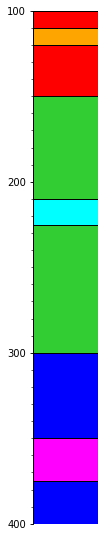

In [12]:
m = _merge_table(s, 'top')
sm = _striplog_from_merge_table(s, m)
sm.plot(legend=legend, lw=1, aspect=5)

In [13]:
_merge_table(s, 'top', reverse=True)

[('T', 100.0, 0),
 ('B', 200.0, 0),
 ('T', 200.0, 2),
 ('B', 325.0, 2),
 ('T', 325.0, 4),
 ('B', 400.0, 4)]

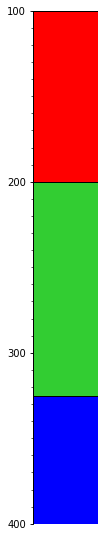

In [14]:
m = _merge_table(s, 'top', reverse=True)
sm = _striplog_from_merge_table(s, m)
sm.plot(legend=legend, lw=1, aspect=5)

This looks correct.

### THICKNESS

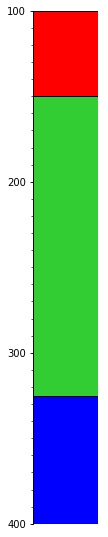

In [15]:
m = _merge_table(s, 'thickness')
sm = _striplog_from_merge_table(s, m)
sm.plot(legend=legend, lw=1, aspect=5)

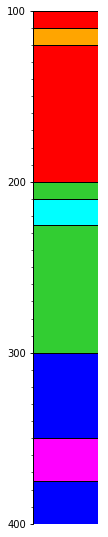

In [16]:
m = _merge_table(s, 'thickness', reverse=True)
sm = _striplog_from_merge_table(s, m)
sm.plot(legend=legend, lw=1, aspect=5)

### AGE

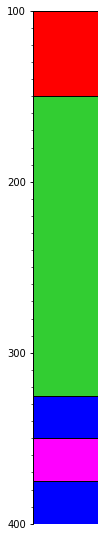

In [17]:
m = _merge_table(s, 'time')
sm = _striplog_from_merge_table(s, m)
sm.plot(legend=legend, lw=1, aspect=5)

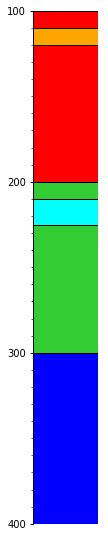

In [18]:
m = _merge_table(s, 'time', reverse=True)
sm = _striplog_from_merge_table(s, m)
sm.plot(legend=legend, lw=1, aspect=5)

## Merge and blend

## Real data example

Intervals are perforations. We want to keep the latest one.

In [19]:
from striplog import Striplog

remap = {'bottom':'base','type':'comp type'}
s = Striplog.from_csv("og815.csv", remap=remap)

In [21]:
from datetime import datetime

for iv in s:
    iv.primary.date = datetime.fromisoformat(iv.data['date'])

In [22]:
s[1]

Interval({'top': Position({'middle': 1992.0, 'units': 'm'}), 'base': Position({'middle': 2005.0, 'units': 'm'}), 'description': '', 'data': {'': 37.0, 'wells': 'OG-815', 'date': '2008-06-23'}, 'components': [Component({'type': 'perforation', 'date': datetime.datetime(2008, 6, 23, 0, 0)})]})

Make a table of interfaces:

- top or base (T or B)
- depth of interface
- index of interval in striplog `s`

Then sort the table by depth.

In [28]:
m = _merge_table(s, 'top')
sm = _striplog_from_merge_table(s, m)

In [29]:
leg = """colour,comp type
limegreen,perforation
red,squeeze"""

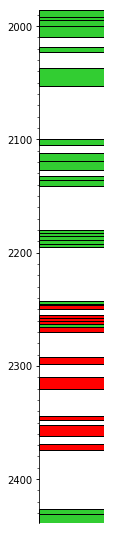

In [31]:
from striplog import Legend

legend = Legend.from_csv(text=leg)

sm.plot(legend, lw=1, aspect=5)

In [33]:
sm.find_overlaps()

In [26]:
s_merge = []
for top, bot in zip(merged[::2], merged[1::2]):
    # If zero thickness, discard.
    if top[1] == bot[1]:
        continue
    i = s[top[2]].copy()
    i.top = top[1]
    i.base = bot[1]
    s_merge.append(i)

m = Striplog(s_merge)

NameError: name 'merged' is not defined

There aren't any! Good &mdash; this striplog should be 'flat'. 

In [34]:
print(sm.to_csv())

Top,Base,Component
1986.0,1992.0,"Perforation, 2008-06-24 00:00:00"
1992.0,1995.0,"Perforation, 2008-06-23 00:00:00"
1995.0,2000.0,"Perforation, 2015-11-14 00:00:00"
2000.0,2010.0,"Perforation, 2018-07-31 00:00:00"
2018.0,2023.0,"Perforation, 2009-10-23 00:00:00"
2037.0,2053.0,"Perforation, 2009-10-23 00:00:00"
2100.0,2105.0,"Perforation, 2018-07-31 00:00:00"
2112.0,2119.0,"Perforation, 2008-04-28 00:00:00"
2119.0,2127.0,"Perforation, 2008-04-28 00:00:00"
2132.0,2136.0,"Perforation, 2012-05-30 00:00:00"
2136.0,2141.0,"Perforation, 2002-06-05 00:00:00"
2180.0,2183.0,"Perforation, 2015-11-14 00:00:00"
2183.0,2185.0,"Perforation, 2012-05-30 00:00:00"
2185.0,2189.0,"Perforation, 2002-06-03 00:00:00"
2189.0,2192.0,"Perforation, 2015-11-13 00:00:00"
2192.0,2195.0,"Perforation, 2002-05-26 00:00:00"
2243.0,2245.0,"Perforation, 2012-05-29 00:00:00"
2245.0,2246.0,"Squeeze, 2008-04-28 00:00:00"
2246.0,2250.0,"Squeeze, 2002-06-03 00:00:00"
2255.0,2258.0,"Squeeze, 2008-04-28 00:00:00"
2258.0,2260.0

This isn't quite right for Petrel.

Let's make another format.

In [39]:
def _to_petrel_csv(strip, attr, null):
    """
    Make Petrel-ready CSV text for a striplog
    """
    csv = ""
    gap_top = 0
    for iv in strip.merge_neighbours():
        if iv.top.middle != gap_top:
            csv += f"{gap_top},{null}\n"
        csv += f"{iv.top.middle},{getattr(iv.primary, attr)}\n"
        gap_top = iv.base.middle
    csv += f"{iv.base.middle},{null}\n"
    return csv

def to_petrel(fname, strip, attr, null=None):
    """
    Make a Petrel-ready CSV file.
    
    Args
        fname (str): the filename, including extension
        strip (Striplog): the striplog
        null (str): what to use for nulls
        
    Returns
        None (writes file as side effect)
    """
    if null is None:
        null = "-999.25"
    with open(fname, 'w') as f:
        f.write(_to_petrel_csv(strip, attr, null))
    return

In [40]:
print(_to_petrel_csv(sm, attr='type', null=-999.25))

0,-999.25
1986.0,perforation
2010.0,-999.25
2018.0,perforation
2023.0,-999.25
2037.0,perforation
2053.0,-999.25
2100.0,perforation
2105.0,-999.25
2112.0,perforation
2127.0,-999.25
2132.0,perforation
2141.0,-999.25
2180.0,perforation
2195.0,-999.25
2243.0,perforation
2245.0,squeeze
2250.0,-999.25
2255.0,squeeze
2263.0,perforation
2266.0,squeeze
2270.0,-999.25
2292.0,squeeze
2298.0,-999.25
2310.0,squeeze
2320.0,-999.25
2344.0,squeeze
2348.0,-999.25
2352.0,squeeze
2362.0,-999.25
2369.0,squeeze
2374.0,-999.25
2426.0,perforation
2439.0,-999.25



In [43]:
to_petrel("well_for_petrel.csv", sm, attr='type')